In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [138]:
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
togpunktlighed_daily = data.groupby('dato')['togpunktlighed'].mean().reset_index()

# SARIMA per strækning

In [143]:
def togpunktlighed_strækning_split(strækning, ratio=0.1):
    strækning_data = data[data['visualiseringskode'] == strækning]
    togpunktlighed_strækning_daily = strækning_data.groupby('dato')['togpunktlighed'].mean().reset_index()['togpunktlighed']
    train, test = train_test_split(togpunktlighed_strækning_daily, test_size=ratio, shuffle=False)
    return train,test

In [152]:
for strækning in data['visualiseringskode'].unique()[3:4]:
    train, test = togpunktlighed_strækning_split(strækning, ratio=0.1)
    m = auto_arima(y=train, 
                          seasonal=True, 
                          stepwise=True, 
                          random_state=42, 
                          m=12,
                          d=1, 
                          D=1,
                          trace=True)
    #sarima=SARIMAX(train,order=m.order,seasonal_order=m.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=6.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2724.692, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3732.640, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3028.840, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-4057.900, Time=1.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=15.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3743.319, Time=1.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4141.567, Time=1.64 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3822.391, Time=0.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=17.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4192.645, Time=2.03 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

In [171]:
n=50
pred=m.fit_predict(train, n_periods=n)
mse = mean_squared_error(test[:n], pred)
print(mse)

0.015106864952869508


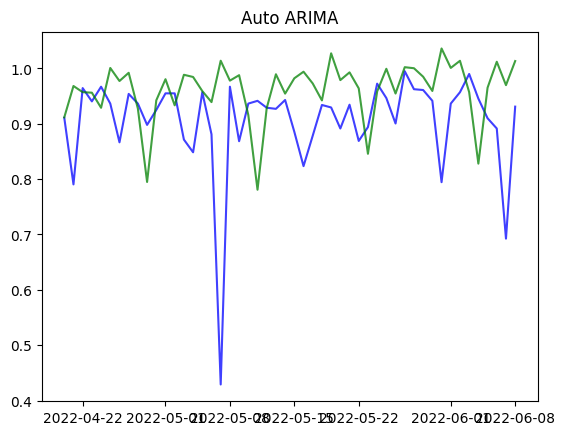

In [170]:
plt.plot(togpunktlighed_daily['dato'][-len(test):-len(test)+len(pred)], test[:len(pred)], alpha=0.75, c='b')
plt.plot(togpunktlighed_daily['dato'][-len(test):-len(test)+len(pred)], pred, alpha=0.75, c='g')  # Forecasts
plt.title("Auto ARIMA")
plt.show()

# "Random" hyperparameters with SARIMAX

In [202]:
ratio = 0.99
train, test = togpunktlighed_daily[:int(togpunktlighed_daily.shape[0]*ratio)], togpunktlighed_daily[int(togpunktlighed_daily.shape[0]*ratio):]
sarima=SARIMAX(train['togpunktlighed'],order=(3,1,3),seasonal_order=(1,1,1,12))

In [203]:
fitted_model=sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53719D+00    |proj g|=  6.07964D+00

At iterate    5    f= -1.58664D+00    |proj g|=  2.76862D-01

At iterate   10    f= -1.60454D+00    |proj g|=  2.70819D-01

At iterate   15    f= -1.63487D+00    |proj g|=  4.09175D-01

At iterate   20    f= -1.66453D+00    |proj g|=  1.48383D+00

At iterate   25    f= -1.68429D+00    |proj g|=  1.73968D-01

At iterate   30    f= -1.69743D+00    |proj g|=  3.00092D-01

At iterate   35    f= -1.69764D+00    |proj g|=  1.14024D-01

At iterate   40    f= -1.69942D+00    |proj g|=  6.25295D-01

At iterate   45    f= -1.70332D+00    |proj g|=  3.13367D-01

At iterate   50    f= -1.70909D+00    |proj g|=  2.00295D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [204]:
fitted_model.predict()

0       0.000000
1       0.884321
2       0.873654
3       0.841167
4       0.821321
          ...   
2526    0.798057
2527    0.812684
2528    0.800037
2529    0.820783
2530    0.810314
Name: predicted_mean, Length: 2531, dtype: float64

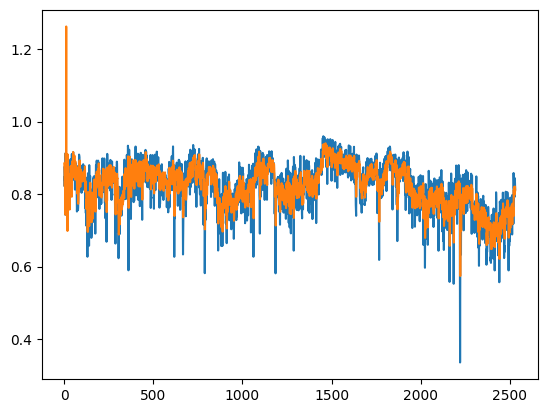

In [205]:
plt.plot(train['togpunktlighed'][1:])
plt.plot(fitted_model.predict()[1:])


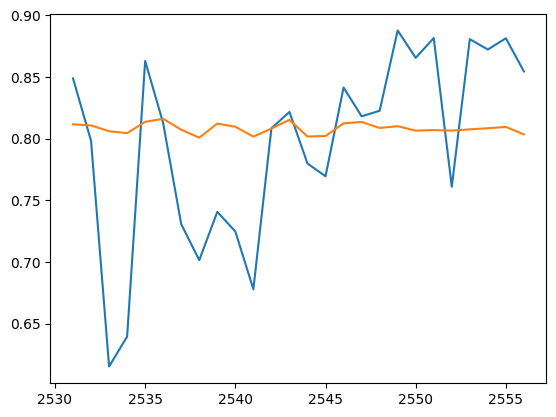

In [206]:
test_preds = fitted_model.predict(start = togpunktlighed_daily.shape[0]-test.shape[0], end = togpunktlighed_daily.shape[0]-1, dynamic=True)


plt.plot(test['togpunktlighed'])
plt.plot(test_preds)

In [207]:
mean_squared_error(test['togpunktlighed'],test_preds)

0.005692386293409624

# All data

In [208]:
ratio = 0.9
train, test = togpunktlighed_daily[:int(togpunktlighed_daily.shape[0]*ratio)], togpunktlighed_daily[int(togpunktlighed_daily.shape[0]*ratio):]

SARIMA_model = auto_arima(train['togpunktlighed'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=4, #12 is the frequncy of the cycle. 4 is quartarly
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-5694.972, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-6528.002, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-5891.598, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-6804.485, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=1.69 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=-6591.416, Time=0.14 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=-6966.555, Time=0.45 sec
 ARIMA(2,1,0)(1,1,0)[4]             : AIC=-6653.455, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=inf, Time=1.42 sec
 ARIMA(2,1,0)(1,1,1)[4]             : AIC=inf, Time=1.15 sec
 ARIMA(3,1,0)(2,1,0)[4]             : AIC=-7035.557, Time=1.02 sec
 ARIMA(3,1,0)(1,1,0)[4]             : AIC=-6684.515, Ti

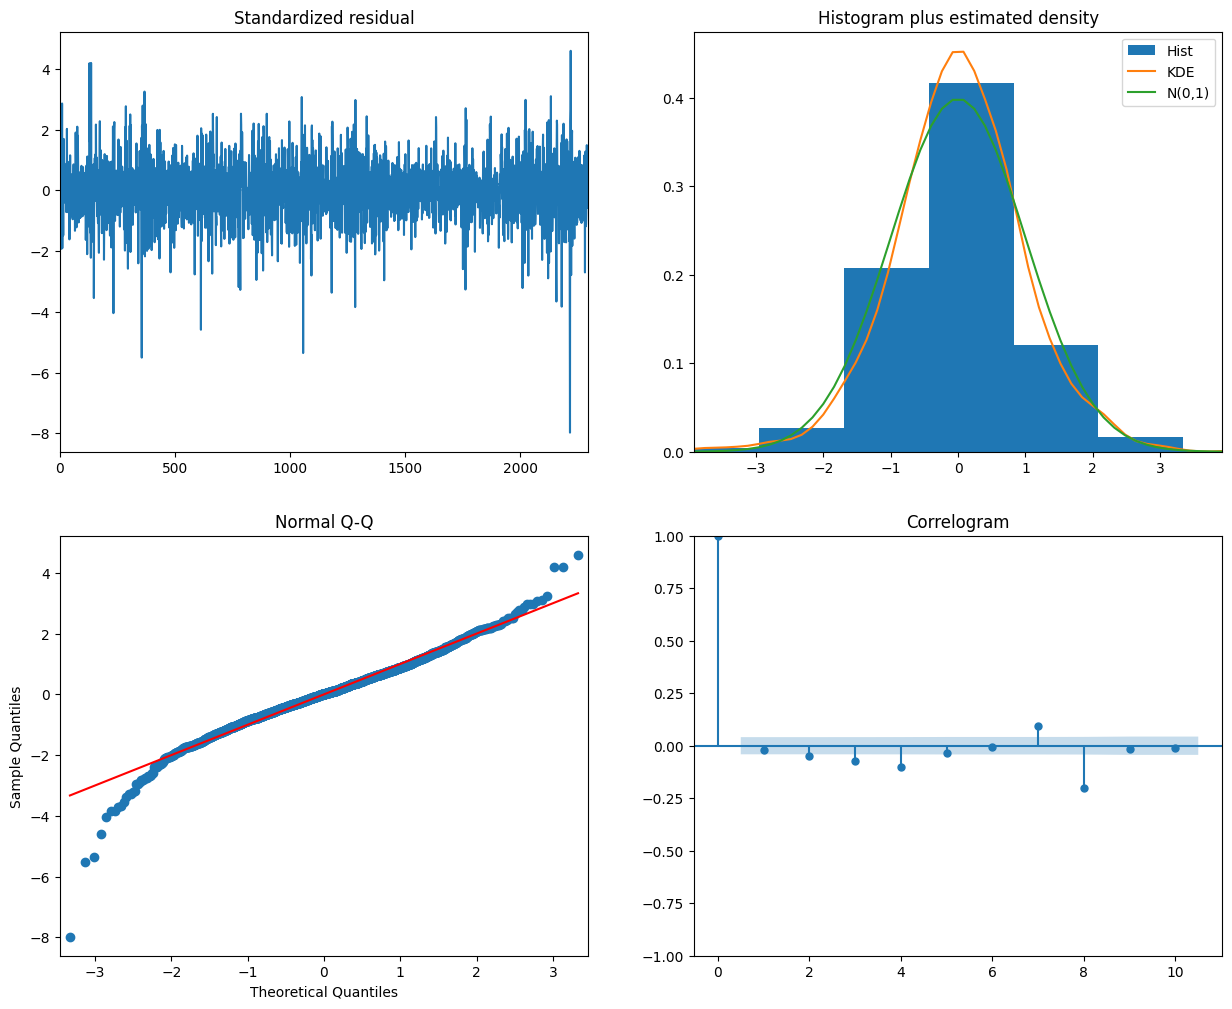

In [16]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

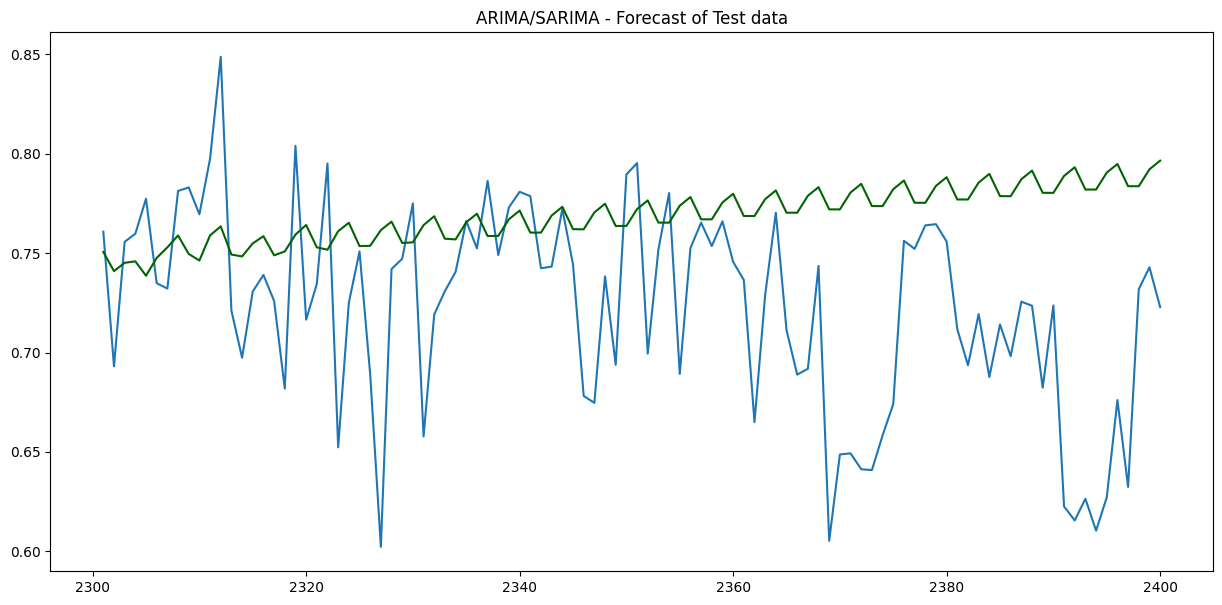

In [210]:
preds = SARIMA_model.predict(n_periods=100)
# Plot
plt.figure(figsize=(15,7))
plt.plot(togpunktlighed_daily['togpunktlighed'][len(train): len(train) + len(preds)], color='#1f76b4')
plt.plot(preds, color='darkgreen')

plt.title("ARIMA/SARIMA - Forecast of Test data")
plt.show()

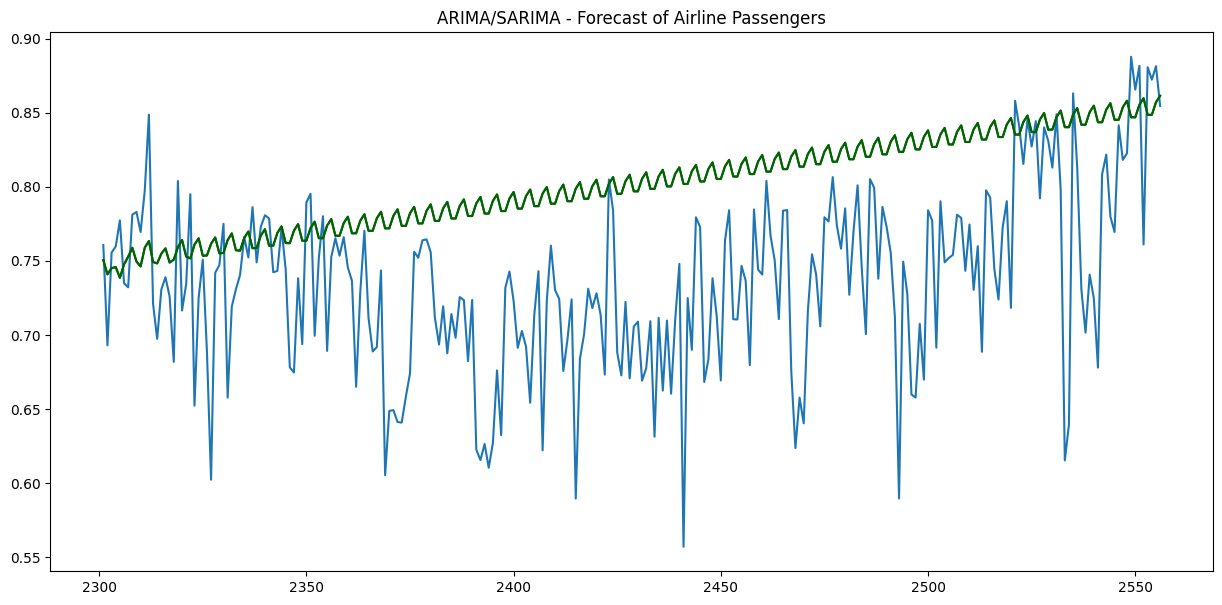

In [211]:
n_periods=test.shape[0]
fitted, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(togpunktlighed_daily['dato'].iloc[-1] + pd.DateOffset(days=1), periods = n_periods, freq='MS')


# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,7))
plt.plot(togpunktlighed_daily['togpunktlighed'][-n_periods:], color='#1f76b4')
plt.plot(fitted, color='darkgreen')
plt.plot(fitted, color='darkgreen')

plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
plt.show()

# Auto ARIMA (med random - strækningsdata ligger underligt)

In [220]:
for strækning in data['visualiseringskode'].unique()[3:4]:
    strækning_data = data[data['visualiseringskode'] == strækning]
    togpunktlighed_strækning_daily = strækning_data.groupby('dato')['togpunktlighed'].mean()
    togpunktlighed_strækning_daily = pd.DataFrame(togpunktlighed_strækning_daily).reset_index()
    train, test = togpunktlighed_strækning_daily[:int(togpunktlighed_strækning_daily.shape[0]*0.9)], togpunktlighed_strækning_daily[int(togpunktlighed_strækning_daily.shape[0]*0.9):]
    m1 = auto_arima(y=train['togpunktlighed'], 
                          seasonal=True, 
                          stepwise=False, 
                          random=True, 
                          random_state=42, 
                          n_fits=5, 
                          n_jobs=-1, 
                          m=1, 
                          trace=True)
    m1.fit(train['togpunktlighed'])

 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=-5068.106, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-5076.843, Time=1.25 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=-4865.523, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-4412.878, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-4897.657, Time=0.16 sec

Best model:  ARIMA(1,1,2)(0,0,0)[1] intercept
Total fit time: 1.453 seconds


In [221]:
forecast = m1.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

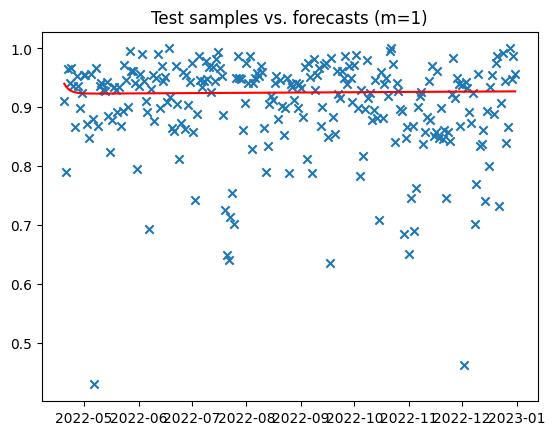

In [222]:
import matplotlib.pyplot as plt

x = np.arange(test.shape[0])

# Plot m=1
plt.scatter(test['dato'], test['togpunktlighed'], marker='x')
plt.plot(test['dato'], forecast, color='red')
plt.title('Test samples vs. forecasts (m=1)')
plt.show()

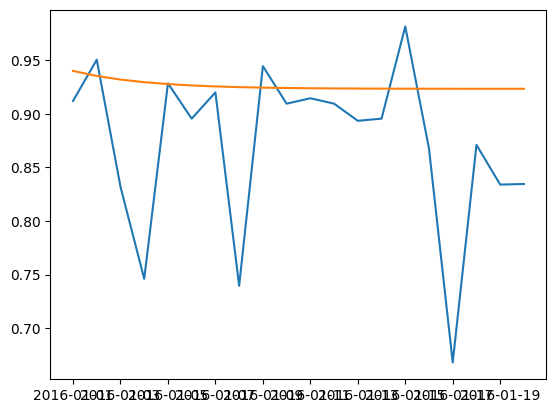

In [223]:
l = 20
forecast1 = m1.predict(n_periods=l)
plt.plot(togpunktlighed_strækning_daily['dato'][:l],togpunktlighed_strækning_daily['togpunktlighed'][:l])
plt.plot(togpunktlighed_strækning_daily['dato'][:l],forecast1)

# Toy data pipeline

Test RMSE: 1258.625


Text(0.5, 0, 'Year')

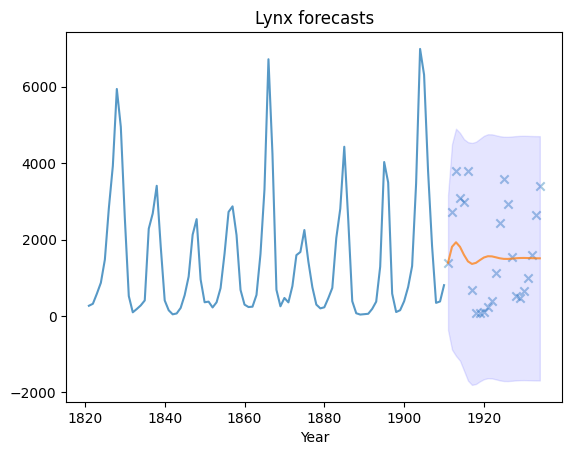

In [25]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# #############################################################################
# Load the data and split it into separate pieces
data = pm.datasets.load_lynx()
train, test = model_selection.train_test_split(data, train_size=90)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1821  # Year starts at 1821

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Lynx forecasts")
plt.xlabel("Year")

Test RMSE: 0.156


Text(0.5, 0, 'Year')

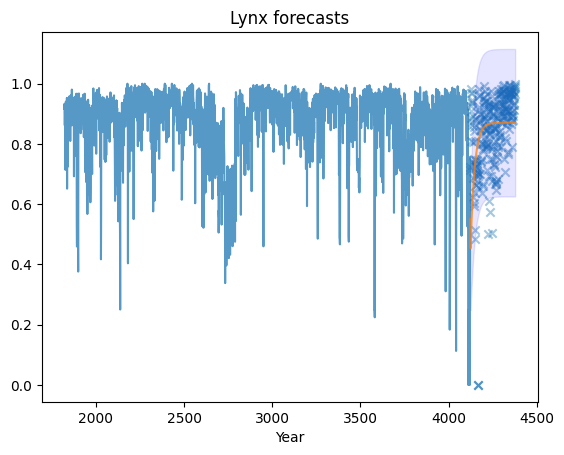

In [226]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# #############################################################################
# Load the data and split it into separate pieces
data = pd.read_parquet("Data/DSB_BDK_trainingset.parquet")
strækning_data = data[data['visualiseringskode'] == 2]
togpunktlighed_strækning_daily = strækning_data.groupby('dato')['togpunktlighed'].mean()
data = pd.DataFrame(togpunktlighed_strækning_daily).reset_index()['togpunktlighed']
train, test = model_selection.train_test_split(data, train_size=0.90)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1821  # Year starts at 1821

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Lynx forecasts")
plt.xlabel("Year")

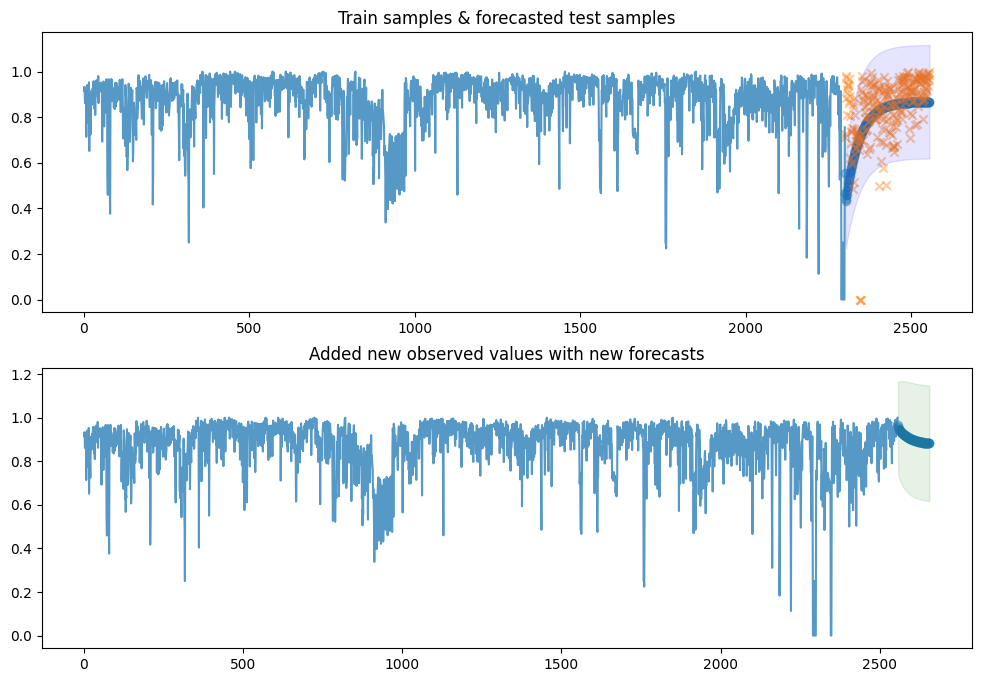

In [227]:
import pmdarima as pm
from pmdarima import model_selection
import matplotlib.pyplot as plt
import numpy as np

# #############################################################################
# Load the data and split it into separate pieces
train, test = model_selection.train_test_split(data, train_size=0.9)

# #############################################################################
# Fit with some validation (cv) samples
arima = pm.auto_arima(train, start_p=1, start_q=1, d=0, max_p=5, max_q=5,
                      out_of_sample_size=10, suppress_warnings=True,
                      stepwise=True, error_action='ignore')

# Now plot the results and the forecast for the test set
preds, conf_int = arima.predict(n_periods=test.shape[0],
                                return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].scatter(x_axis[train.shape[0]:], preds, alpha=0.4, marker='o')
axes[0].scatter(x_axis[train.shape[0]:], test, alpha=0.4, marker='x')
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

# fill the section where we "held out" samples in our model fit

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
new_preds, new_conf_int = arima.predict(n_periods=100, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 100)

axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()

# Decompose (weekly and daily interesting)

Text(0.5, 1.0, 'Multiplicative Seasonal Decomposition')

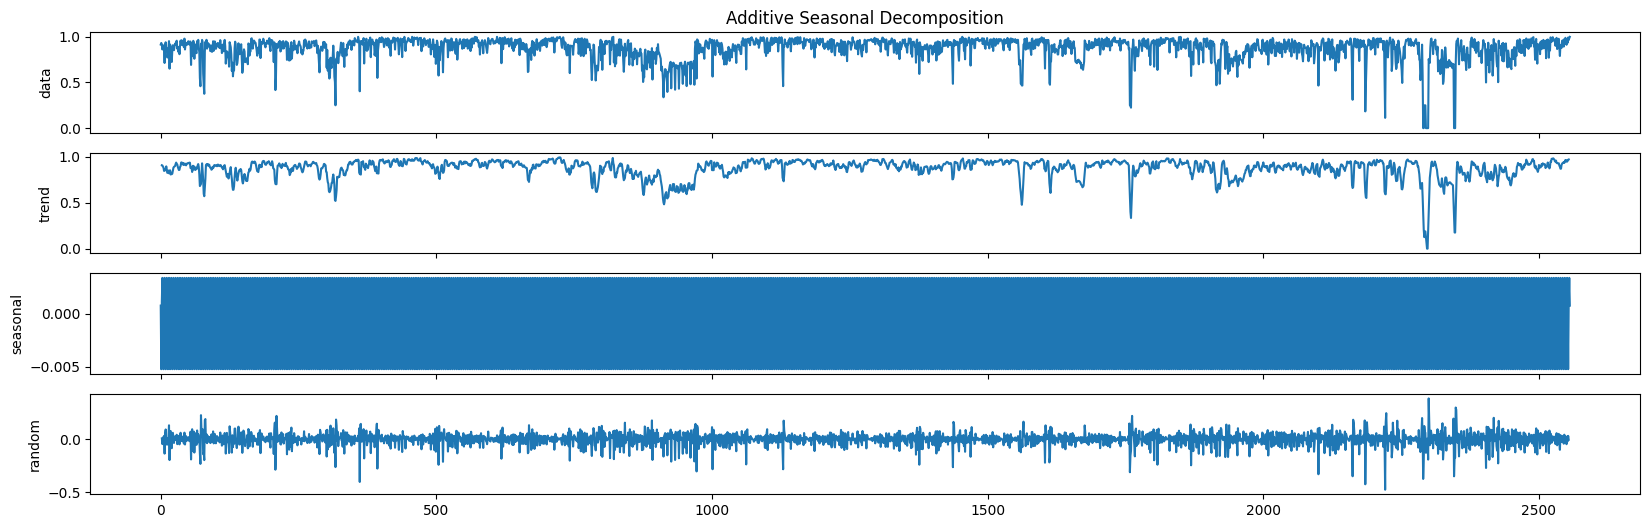

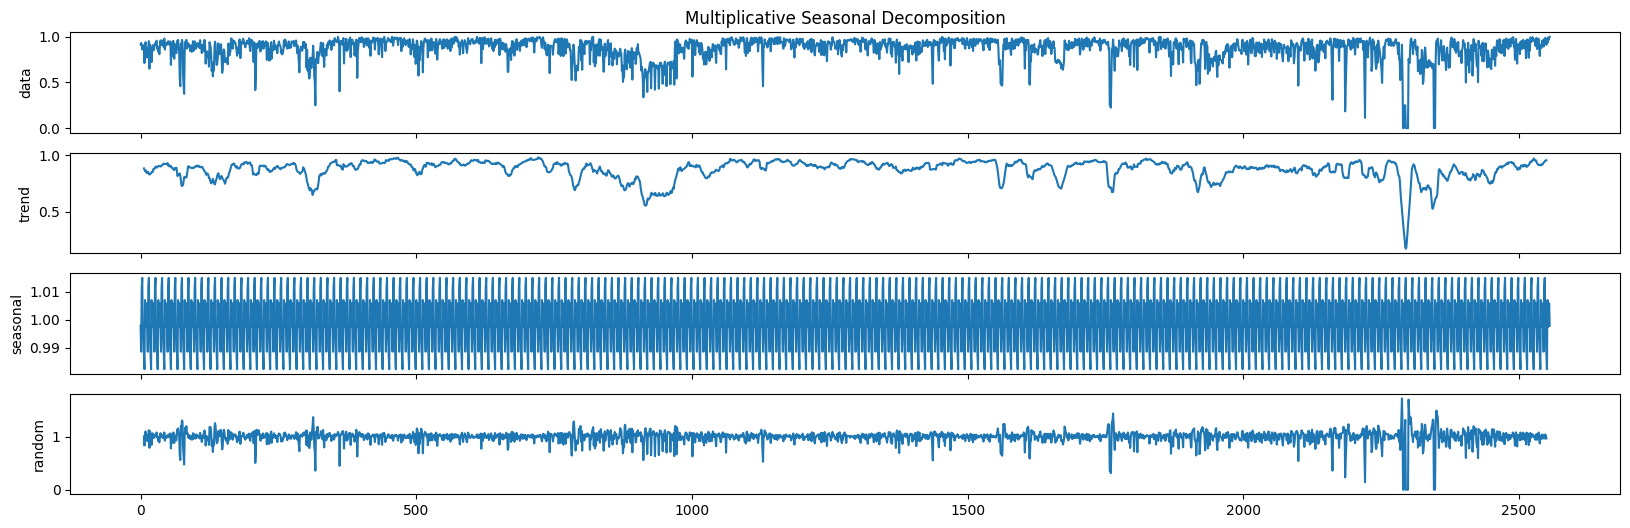

In [228]:

from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

figure_kwargs = {'figsize': (20, 6)}  # set figure size for both examples
decomposed = arima.decompose(data, 'additive', m=4)

# Plot the decomposed signal of ausbeer as a subplot

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("Additive Seasonal Decomposition")


#
# MULTIPLICATIVE EXAMPLE: airpassengers
#

# Decompose the airpassengers dataset into trend, seasonal and random parts.
decomposed = arima.decompose(data,
                             'multiplicative', m=12)

# Plot the decomposed signal of airpassengers as a subplot

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("Multiplicative Seasonal Decomposition")

# Cross Validation

In [229]:
import warnings
warnings.filterwarnings("ignore")
est = pm.ARIMA(order=(1, 1, 2),
               seasonal_order=(0, 1, 1, 12),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=150, step=4, h=4)
predictions = model_selection.cross_val_predict(
    est, data, cv=cv, verbose=2, averaging="median")

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

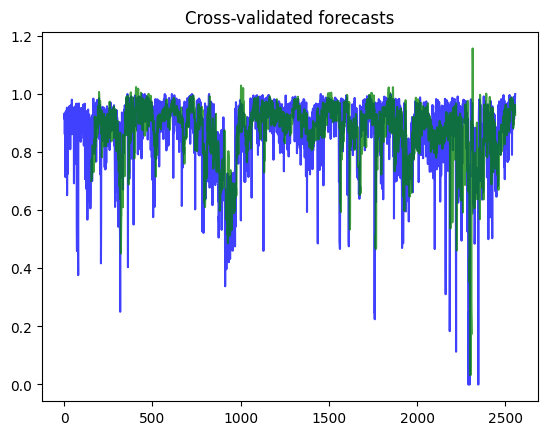

In [230]:
# plot the predictions over the original series
x_axis = np.arange(data.shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, data, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [231]:
mse = mean_squared_error(data[-n_test:], predictions)
print(mse)

0.016892568897010584


# Article

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

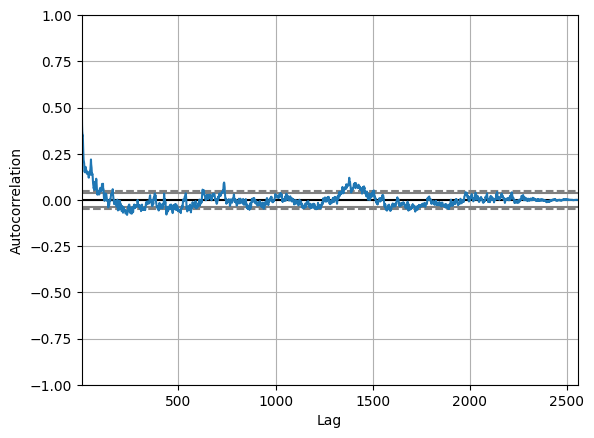

In [232]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)

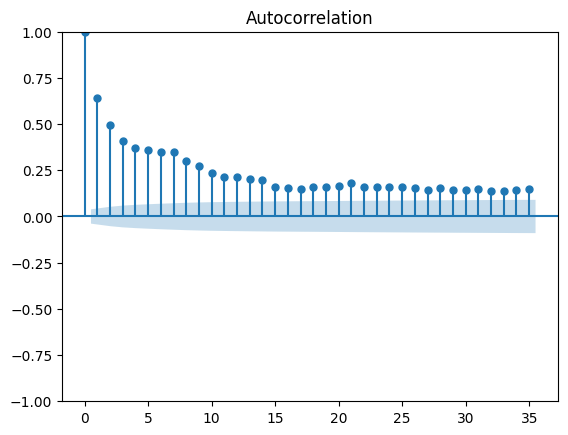

In [233]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data)
plt.show()

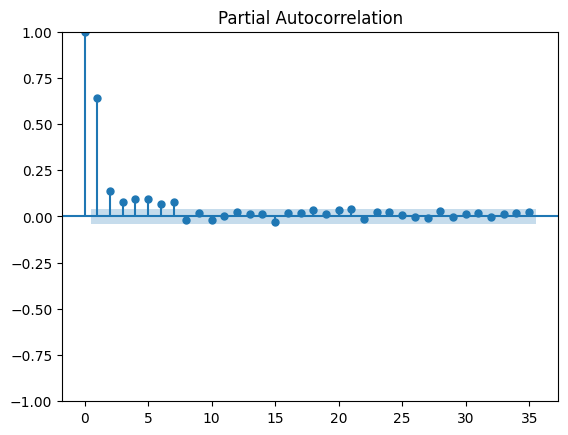

In [234]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data)
plt.show()

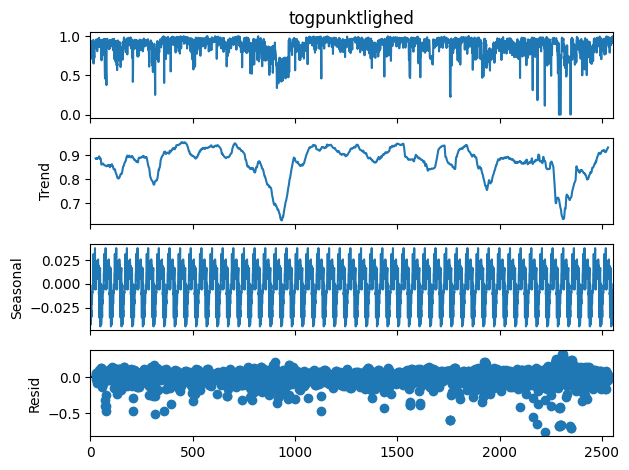

In [235]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(data,model='additive',period=52) # CHANGE period depending on seasonality
decomposition.plot()
plt.show()

In [236]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.99997564525058
2. P-Value :  1.8955853238588376e-17
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2550
5. Critical Values :
	 1% :  -3.43291701763171
	 5% :  -2.862674104529329
	 10% :  -2.567373726105344


In [237]:
model12=auto_arima(data,start_p=1,start_q=1,test='adf',seasonal=False,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4623.271, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6610.031, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3553.787, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4814.815, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-4820.208, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-4823.352, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-4823.104, Time=0.67 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-4617.056, Time=0.65 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.87 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-4818.858, Time

In [238]:
sarima1=SARIMAX(data,order=(5,0,2),seasonal_order=(0,0,0,0))

predicted1=sarima1.fit().predict();predicted1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.36356D-01    |proj g|=  2.38768D-01

At iterate    5    f= -9.38812D-01    |proj g|=  3.65164D-02

At iterate   10    f= -9.38997D-01    |proj g|=  1.55292D-01


 This problem is unconstrained.



At iterate   15    f= -9.40826D-01    |proj g|=  2.52324D-01

At iterate   20    f= -9.43565D-01    |proj g|=  3.12646D-02

At iterate   25    f= -9.43781D-01    |proj g|=  1.07275D-02

At iterate   30    f= -9.43835D-01    |proj g|=  2.49835D-03

At iterate   35    f= -9.43851D-01    |proj g|=  2.49971D-02

At iterate   40    f= -9.44284D-01    |proj g|=  1.98065D-01

At iterate   45    f= -9.45075D-01    |proj g|=  1.59210D-01

At iterate   50    f= -9.45416D-01    |proj g|=  6.59359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   6.594D-03  -9.454D-01
  F = -0.945416193856

0       0.000000
1       0.906123
2       0.921074
3       0.912117
4       0.878494
          ...   
2552    0.949771
2553    0.932697
2554    0.962588
2555    0.951544
2556    0.962692
Name: predicted_mean, Length: 2557, dtype: float64

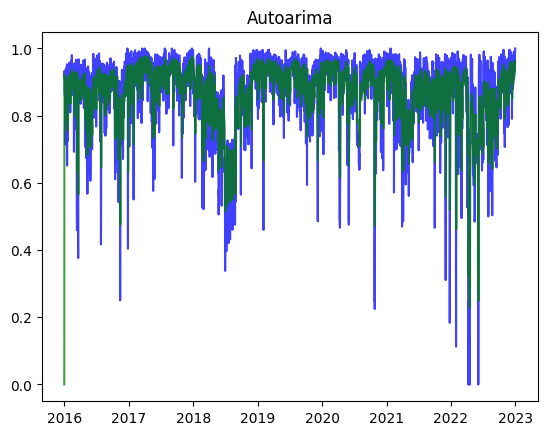

In [239]:
plt.plot(togpunktlighed_daily['dato'], data, alpha=0.75, c='b')
plt.plot(togpunktlighed_daily['dato'], predicted1, alpha=0.75, c='g')  # Forecasts
plt.title("Autoarima")
plt.show()

In [240]:
mse = mean_squared_error(data[-len(predicted1):], predicted1)
print(mse)

0.009144305248893736


In [241]:
model12_seasonal=auto_arima(data,start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-3374.460, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-4737.424, Time=2.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4287.610, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6610.031, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-4732.110, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-4738.870, Time=6.21 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=9.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-3525.435, Time=4.38 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-3955.990, Time=7.15 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-3892.401, Time=7.01 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-4117.836, Time=4.85 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-3841.228, Time=7.79 sec
 ARIMA(1,0,0)(2,0,0)[12]

In [242]:
sarima1=SARIMAX(data,order=(1,0,0),seasonal_order=(2,0,0,12))

predicted1=sarima1.fit().predict();predicted1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.80223D-01    |proj g|=  4.51747D+00

At iterate    5    f= -6.23723D-01    |proj g|=  2.12423D-02


 This problem is unconstrained.



At iterate   10    f= -6.23992D-01    |proj g|=  1.25026D-01

At iterate   15    f= -6.24091D-01    |proj g|=  1.57725D-02

At iterate   20    f= -6.24612D-01    |proj g|=  2.03008D-01

At iterate   25    f= -8.08416D-01    |proj g|=  1.68745D+00

At iterate   30    f= -8.24063D-01    |proj g|=  5.80484D-03

At iterate   35    f= -8.28351D-01    |proj g|=  2.51142D-02

At iterate   40    f= -8.29014D-01    |proj g|=  2.31638D-03

At iterate   45    f= -8.29022D-01    |proj g|=  7.21187D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     75      1     0     0   7.212D-05  -8.290D-01
  F = -0.829021677137


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


0       0.000000
1       0.909191
2       0.926315
3       0.908202
4       0.855596
          ...   
2552    0.966580
2553    0.927864
2554    0.985989
2555    0.958771
2556    0.977603
Name: predicted_mean, Length: 2557, dtype: float64

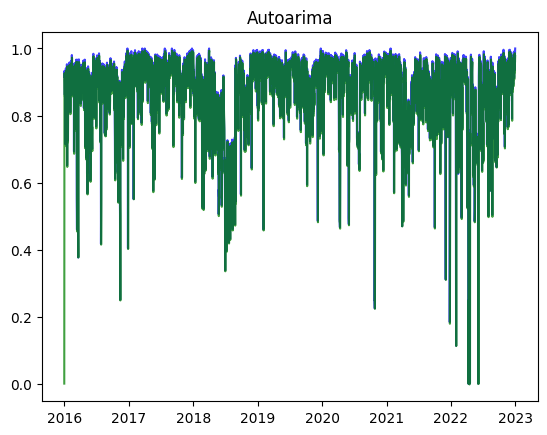

In [243]:
plt.plot(togpunktlighed_daily['dato'], data, alpha=0.75, c='b')
plt.plot(togpunktlighed_daily['dato'][-len(predicted1):], predicted1, alpha=0.75, c='g')  # Forecasts
plt.title("Autoarima")
plt.show()

In [244]:
mse = mean_squared_error(data[-len(predicted1):], predicted1)
print(mse)

0.01145916653261391
